In [1]:
import stlearn as st
import multimodal_cci as mmcci

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.int = np.int32
np.float = np.float32

/home/uqlhocke/micromamba/envs/stlearn/lib/python3.10/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)
/home/uqlhocke/micromamba/envs/stlearn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-30 15:56:20.495907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-

### Load in Visium and Xenium Datasets

In [2]:
data_dir = "/QRISdata/Q1851/Andrew_C/Other_Project/QIMR_Workshop/data/skin_data"

visium = st.Read10X(
    path=f"{data_dir}/Visium_Raw"
    )

xenium = st.ReadXenium(
    feature_cell_matrix_file=f"{data_dir}/Xenium_Raw/cell_feature_matrix.h5",
    cell_summary_file=f"{data_dir}/Xenium_Raw/cells.csv.gz"
    )

## Run Visium stLearn CCI

In [3]:
visium.var_names_make_unique()

# Basic normalisation #
st.pp.filter_genes(visium, min_cells=3)
st.pp.normalize_total(visium) # NOTE: no log1p

Normalization step is finished in adata.X


In [4]:
card_path = f"{data_dir}/../../visium_decon.csv"

spot_mixtures = pd.read_csv(card_path, index_col=0)
spot_mixtures.head()

,KC_Cornified,KC_Differentiating,Imm_CD8+ T cell,KC_stem/hair/stress,Imm_Treg,Imm_pDC,Imm_Tcell,Imm_NK,Imm_Fibroblast,Imm_DC,KC_Basal,Melanocytes,Imm_Endothelial cell,KC_Granular,Imm_Macrophage,Imm_Bcells,Pericytes,Imm_Mast Cells,Imm_mRegDC,Imm_LC
AACACGTGCATCGCAC-1,0.000174,0.000097,0.000027,0.000132,0.000050,0.000004,0.000142,0.000169,0.905402,0.000141,0.000023,0.000767,0.003335,0.000004,0.005032,0.000003,0.000280,0.079345,0.004859,0.000013
AACAGGAAGAGCATAG-1,0.000426,0.000025,0.000029,0.000592,0.000020,0.000063,0.000096,0.000149,0.938201,0.000091,0.000021,0.000563,0.000149,0.000003,0.035068,0.000246,0.000063,0.020485,0.003585,0.000126
AACATCTAATGACCGG-1,0.000477,0.001880,0.000343,0.000126,0.000646,0.000048,0.000290,0.000203,0.880508,0.000104,0.000075,0.006640,0.005725,0.000053,0.100708,0.000282,0.000172,0.000433,0.001279,0.000007
AACATGCGCAAGTGAG-1,0.028730,0.151483,0.000510,0.103867,0.000400,0.001234,0.001490,0.001269,0.584374,0.007005,0.014522,0.010340,0.044565,0.004491,0.010533,0.000453,0.001305,0.025258,0.002427,0.005744
AACCAGAATCAGACGT-1,0.073579,0.729156,0.000659,0.007295,0.000668,0.000737,0.000667,0.001071,0.028985,0.002153,0.109877,0.017037,0.015493,0.000344,0.001585,0.000179,0.005739,0.000578,0.002308,0.001892


In [5]:
spot_mixtures['predicted_cell_type'] = spot_mixtures.idxmax(axis=1) # Get the cell type with the highest proportion
labels = spot_mixtures.loc[:,'predicted_cell_type'].values.astype(str) # Get the cell type labels
spot_mixtures = spot_mixtures.drop(['predicted_cell_type'], axis=1) # Drop the predicted cell type column

# Subset the visium to only include spots in the spot mixtures
visium = visium[spot_mixtures.index.values]

print('Spot mixture order correct?: ',
    np.all(spot_mixtures.index.values==visium.obs_names.values)) # Check is in correct order

# NOTE: using the same key in data.obs & data.uns
visium.obs['cell_type'] = labels # Adding the dominant cell type labels per spot
visium.obs['cell_type'] = visium.obs['cell_type'].astype('category')
visium.uns['cell_type'] = spot_mixtures # Adding the cell type scores

Spot mixture order correct?:  True


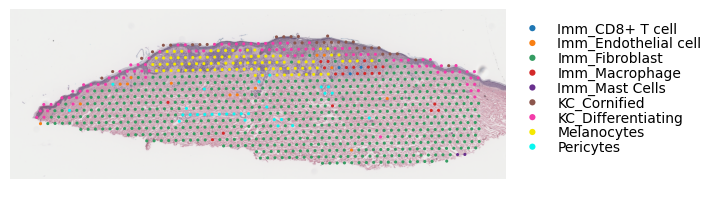

In [6]:
st.pl.cluster_plot(visium, use_label='cell_type')

In [7]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))

2293


In [8]:
# Running the analysis #
st.tl.cci.run(visium, lrs,
                min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                n_pairs=1000, # Number of random pairs to generate; low as example, recommend ~10,000
                n_cpus=6, # Number of CPUs for parallel. If None, detects & use all available.
                )

Calculating neighbours...
0 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 1283 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]  


Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


In [9]:
lr_info = visium.uns['lr_summary'] # A dataframe detailing the LR pairs ranked by number of significant spots.
print('\n', lr_info)

st.tl.cci.adj_pvals(visium, correct_axis='spot',
                pval_adj_cutoff=0.05, adj_method='fdr_bh')


               n_spots  n_spots_sig  n_spots_sig_pval
COL1A1_CD44       916          639               768
COL1A2_CD44       916          576               714
COL1A1_DDR2       815          516               624
VIM_CD44          915          490               685
COL1A1_ITGB1      731          437               536
...               ...          ...               ...
CXCL2_XCR1         31            0                10
FGF1_FGFR2        120            0                16
DHH_BOC            43            0                20
SNCA_LAG3         131            0                27
ZP3_MERTK          32            0                 9

[1283 rows x 3 columns]
Updated adata.uns[lr_summary]
Updated adata.obsm[lr_scores]
Updated adata.obsm[lr_sig_scores]
Updated adata.obsm[p_vals]
Updated adata.obsm[p_adjs]
Updated adata.obsm[-log10(p_adjs)]


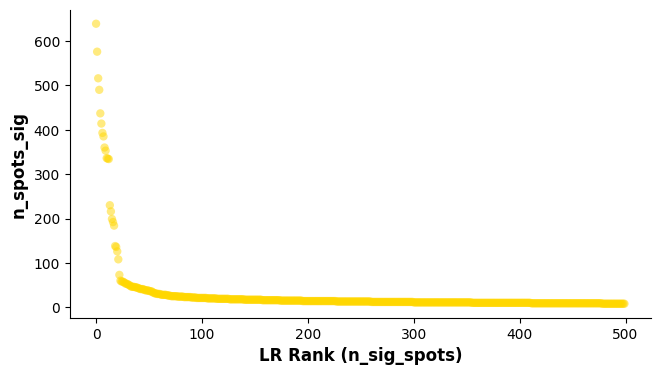

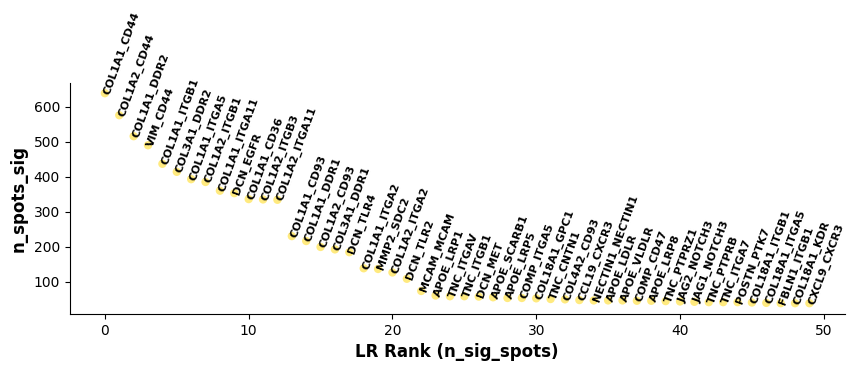

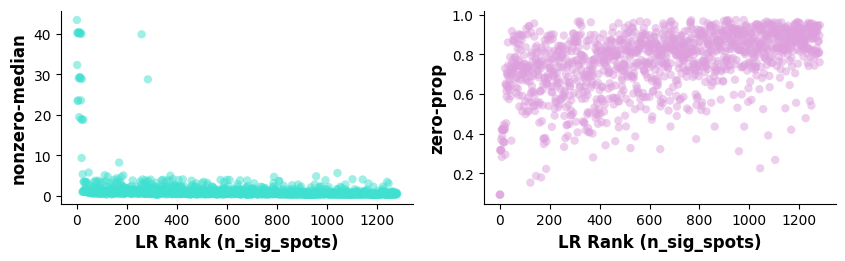

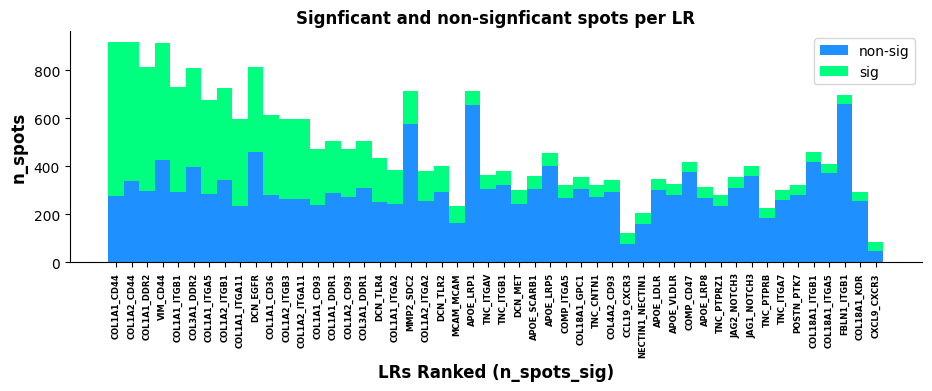

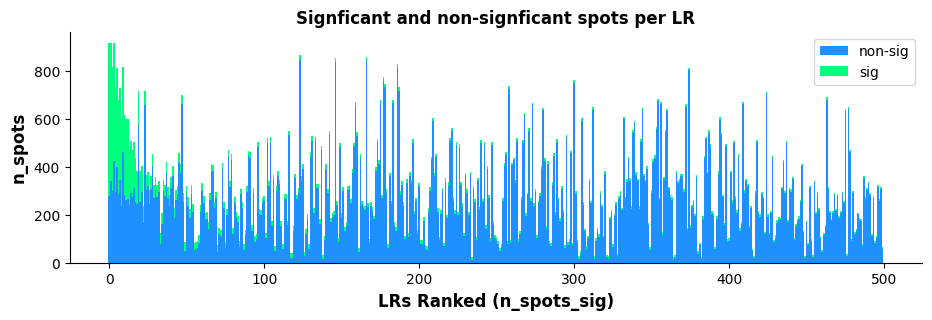

In [10]:
# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(visium, n_top=500)
st.pl.lr_summary(visium, n_top=50, figsize=(10,3))

st.pl.lr_diagnostics(visium, figsize=(10,2.5))

st.pl.lr_n_spots(visium, n_top=50, figsize=(11, 3),
                    max_text=100)
st.pl.lr_n_spots(visium, n_top=500, figsize=(11, 3),
                    max_text=100)

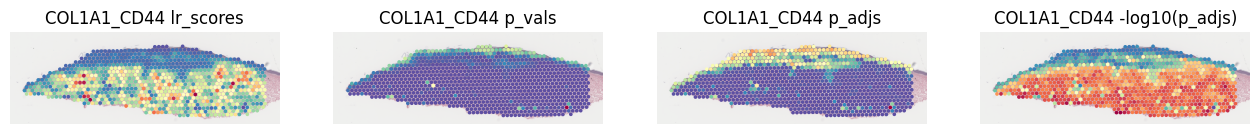

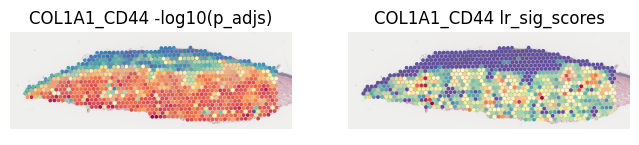

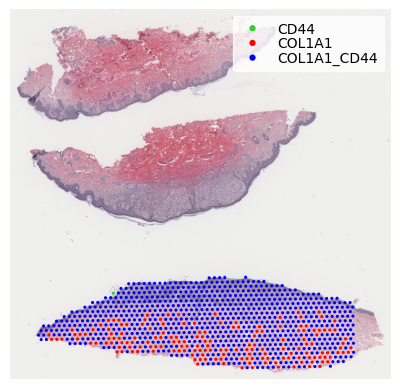

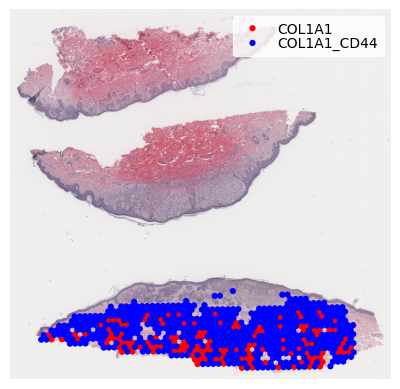

In [11]:
best_lr = visium.uns['lr_summary'].index.values[0] # Just choosing one of the top from lr_summary

stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']
fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(visium, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])
    axes[i].set_title(f'{best_lr} {stat}')
    
fig, axes = plt.subplots(ncols=2, figsize=(8,6))
st.pl.lr_result_plot(visium, use_result='-log10(p_adjs)', use_lr=best_lr, show_color_bar=False, ax=axes[0])
st.pl.lr_result_plot(visium, use_result='lr_sig_scores', use_lr=best_lr, show_color_bar=False, ax=axes[1])
axes[0].set_title(f'{best_lr} -log10(p_adjs)')
axes[1].set_title(f'{best_lr} lr_sig_scores')

st.pl.lr_plot(visium, best_lr, inner_size_prop=0.1, outer_mode='binary', pt_scale=5,
            use_label=None, show_image=True,
            sig_spots=False)

st.pl.lr_plot(visium, best_lr, outer_size_prop=1, outer_mode='binary', pt_scale=20,
            use_label=None, show_image=True,
            sig_spots=True)

Getting cached neighbourhood information...
Getting information for CCI counting...


Counting celltype-celltype interactions per LR and permutating 100 times.:   0%|           [ time left: ? ]

Counting celltype-celltype interactions per LR and permutating 100 times.: 100%|██████████ [ time left: 00:00 ]   


Significant counts of cci_rank interactions for all LR pairs in data.uns[lr_cci_cell_type]
Significant counts of cci_rank interactions for each LR pair stored in dictionary data.uns[per_lr_cci_cell_type]


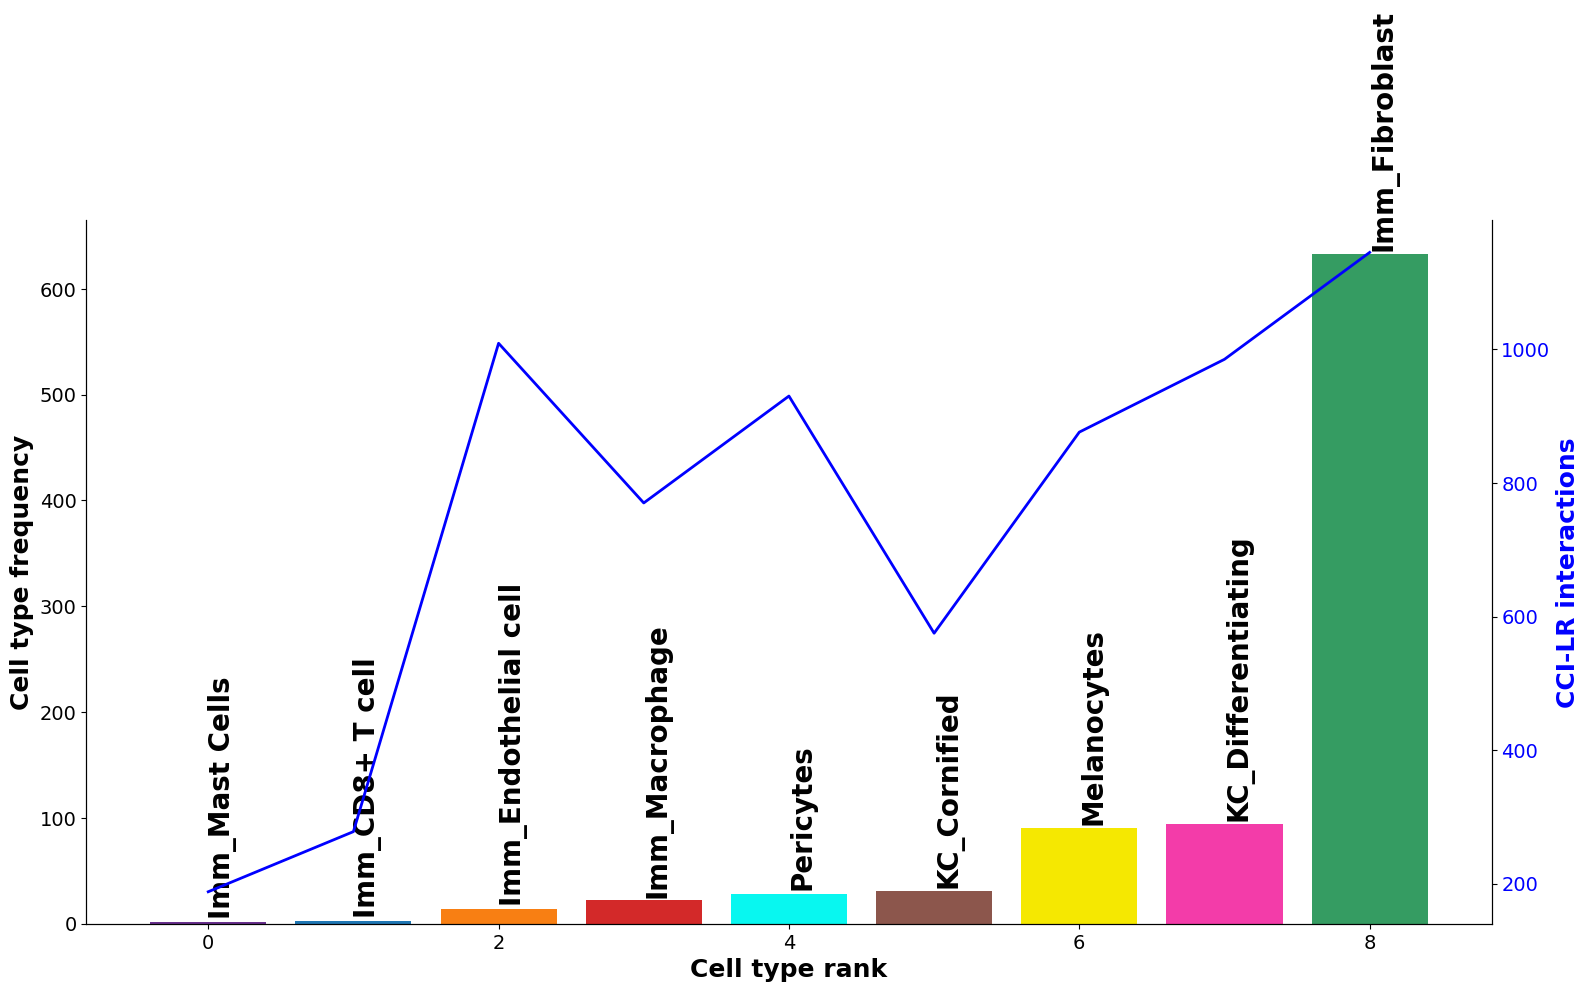

In [12]:
# Running the counting of co-occurence of cell types and LR expression hotspots #
st.tl.cci.run_cci(visium, 'cell_type', # Spot cell information either in data.obs or data.uns
                min_spots=3, # Minimum number of spots for LR to be tested.
                spot_mixtures=True, # If True will use the label transfer scores,
                                    # so spots can have multiple cell types if score>cell_prop_cutoff
                cell_prop_cutoff=0.2, # Spot considered to have cell type if score>0.2
                sig_spots=True, # Only consider neighbourhoods of spots which had significant LR scores.
                n_perms=100, # Permutations of cell information to get background, recommend ~1000,
                n_cpus=6 # Number of CPUs for parallel. If None, detects & use all available.
                )

st.pl.cci_check(visium, 'cell_type')

In [18]:
del visium.uns['lr_summary']
del visium.uns['lrfeatures']

visium.write_h5ad(f"{data_dir}/visium_stlearn.h5ad")

## Run Xenium stLearn CCI

In [19]:
xenium.var_names_make_unique()

# Basic normalisation #
st.pp.filter_genes(xenium, min_cells=3)
st.pp.normalize_total(xenium) # NOTE: no log1p

Normalization step is finished in adata.X


In [20]:
lt_path = f"{data_dir}/../../xenium_label_transfer.csv"

spot_mixtures = pd.read_csv(lt_path, index_col=0)
spot_mixtures.head()

,cell_types
aaaanabd-1,Imm_LC
aaagncnp-1,Imm_Fibroblast
aaahjphg-1,Imm_Fibroblast
aaaipkle-1,Melanocytes
aaajabff-1,Imm_Fibroblast


In [21]:
labels = spot_mixtures.loc[:,'cell_types'].values.astype(str) # Get the cell type labels

# Subset the xenium to only include spots in the spot mixtures
xenium = xenium[spot_mixtures.index.values]

print('Spot mixture order correct?: ',
    np.all(spot_mixtures.index.values==xenium.obs_names.values)) # Check is in correct order

# NOTE: using the same key in data.obs & data.uns
xenium.obs['cell_type'] = labels # Adding the dominant cell type labels per spot
xenium.obs['cell_type'] = xenium.obs['cell_type'].astype('category')

Spot mixture order correct?:  True


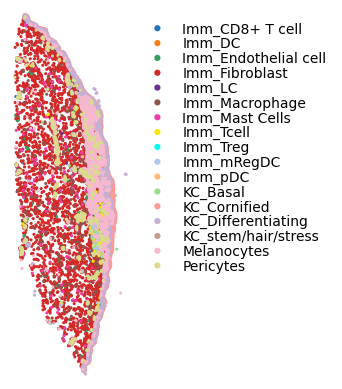

In [22]:
st.pl.cluster_plot(xenium, use_label='cell_type')

In [23]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))

2293


In [34]:
# Running the analysis #
st.tl.cci.run(xenium, lrs,
                min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                distance=50, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                n_pairs=10000, # Number of random pairs to generate; low as example, recommend ~10,000
                n_cpus=6, # Number of CPUs for parallel. If None, detects & use all available.
                )

Calculating neighbours...
138 spots with no neighbours, 57 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 13 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]


Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


In [35]:
lr_info = xenium.uns['lr_summary'] # A dataframe detailing the LR pairs ranked by number of significant spots.
print('\n', lr_info)

st.tl.cci.adj_pvals(xenium, correct_axis='spot',
                pval_adj_cutoff=0.05, adj_method='fdr_bh')


               n_spots  n_spots_sig  n_spots_sig_pval
CXCL12_ITGB1    17330         5091              8053
FBLN1_ITGB1     16574         2751              4005
APOD_LEPR       10692         2505              4473
THBS2_ITGB1     16944         2316              4576
CXCL12_CXCR4     5344         1567              2567
THBS2_ITGA6     12532          456              1981
THBS2_NOTCH3     9148          369              1214
CXADR_CXADR      4141          341              2470
ADAM12_ITGB1    10470          324              1771
C1QA_CD93        2269          149               486
MYL9_CD69        2450          136               439
CCL19_CCR7       1243           92               325
TFF3_CXCR4        203            5                11
Updated adata.uns[lr_summary]
Updated adata.obsm[lr_scores]
Updated adata.obsm[lr_sig_scores]
Updated adata.obsm[p_vals]
Updated adata.obsm[p_adjs]
Updated adata.obsm[-log10(p_adjs)]


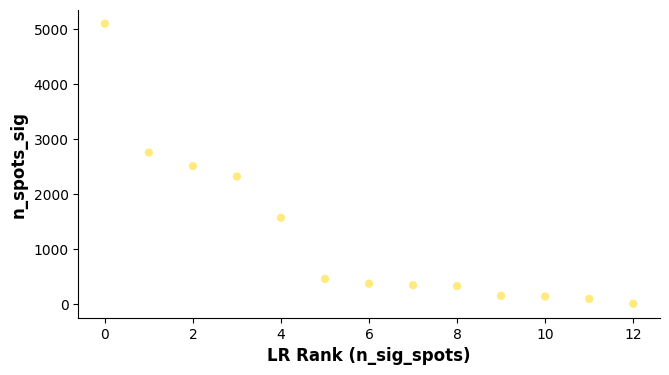

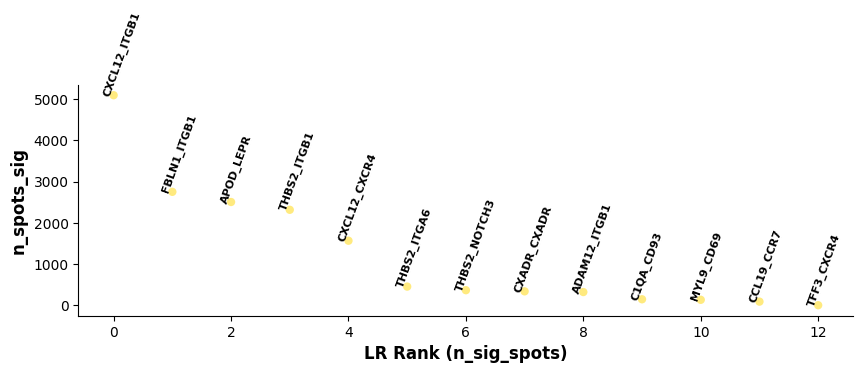

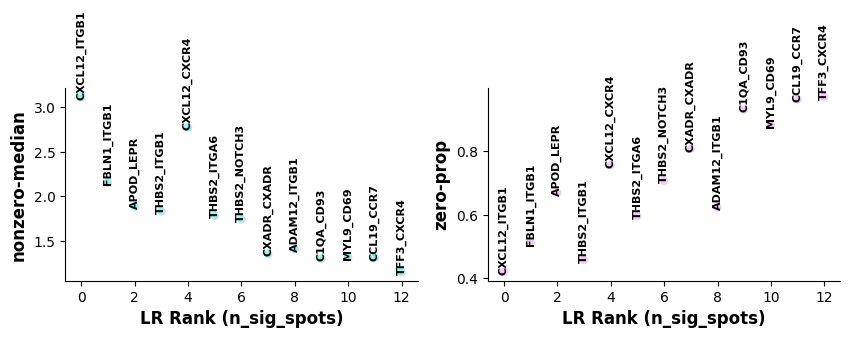

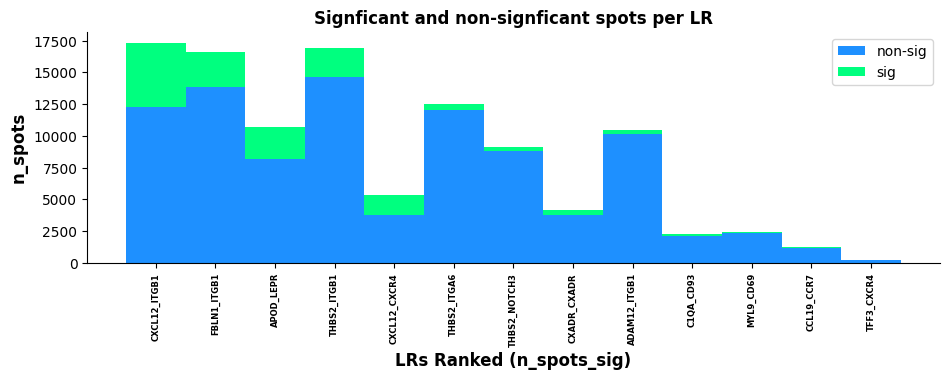

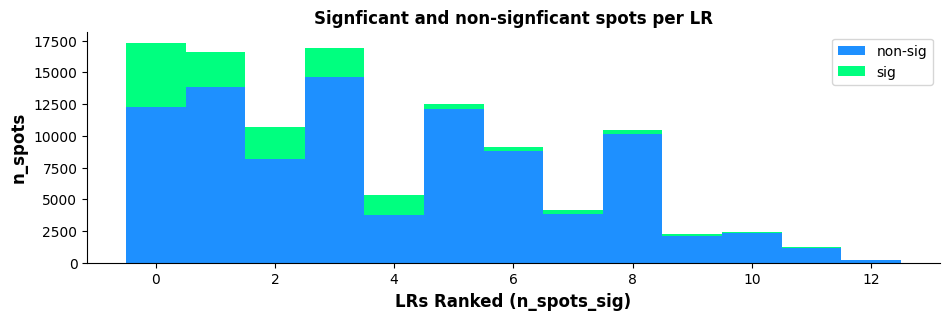

In [36]:
# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(xenium, n_top=500)
st.pl.lr_summary(xenium, n_top=50, figsize=(10,3))

st.pl.lr_diagnostics(xenium, figsize=(10,2.5))

st.pl.lr_n_spots(xenium, n_top=50, figsize=(11, 3),
                    max_text=100)
st.pl.lr_n_spots(xenium, n_top=500, figsize=(11, 3),
                    max_text=100)

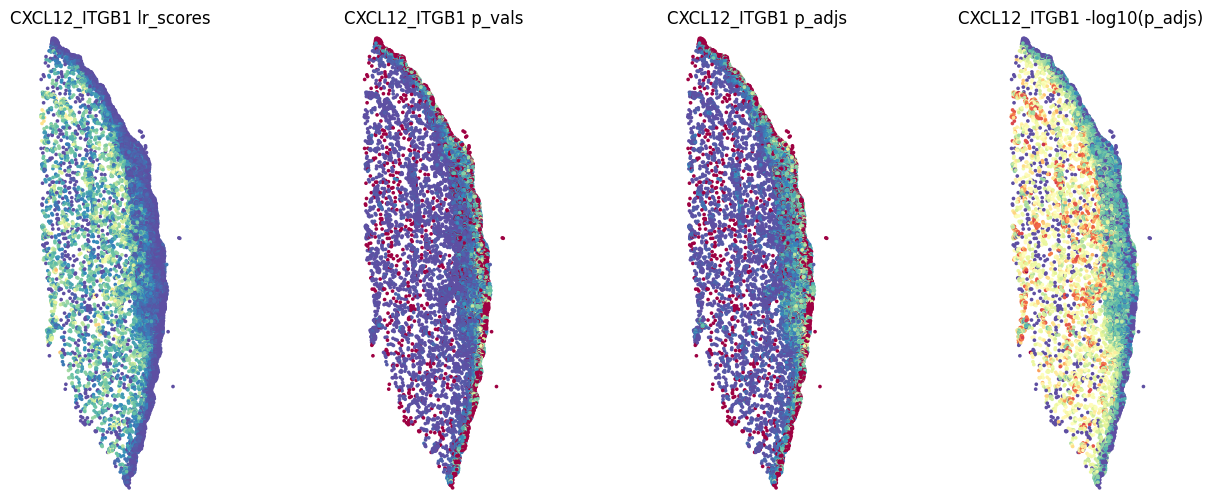

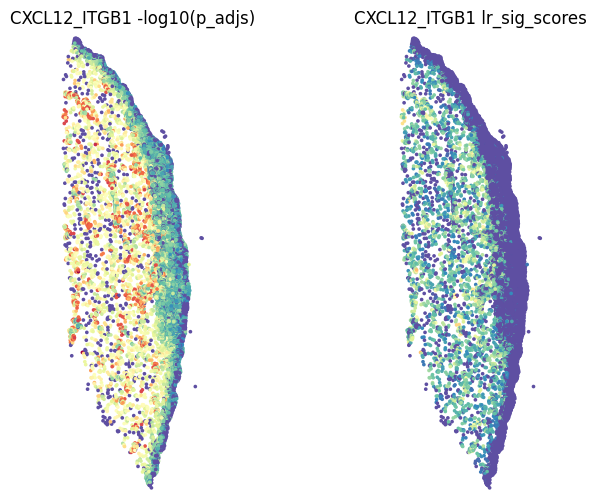

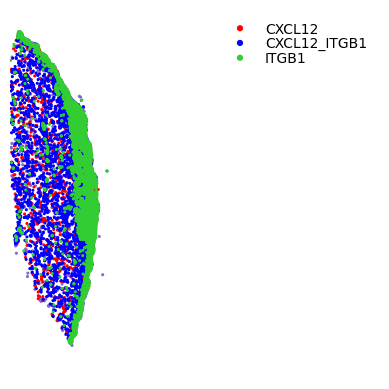

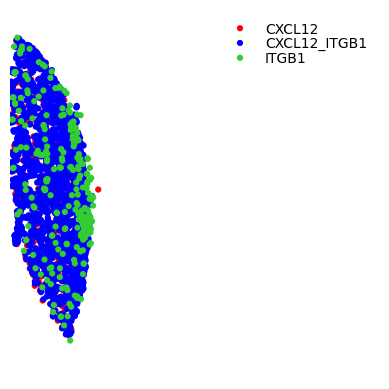

In [37]:
best_lr = xenium.uns['lr_summary'].index.values[0] # Just choosing one of the top from lr_summary

stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']
fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(xenium, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])
    axes[i].set_title(f'{best_lr} {stat}')
    
fig, axes = plt.subplots(ncols=2, figsize=(8,6))
st.pl.lr_result_plot(xenium, use_result='-log10(p_adjs)', use_lr=best_lr, show_color_bar=False, ax=axes[0])
st.pl.lr_result_plot(xenium, use_result='lr_sig_scores', use_lr=best_lr, show_color_bar=False, ax=axes[1])
axes[0].set_title(f'{best_lr} -log10(p_adjs)')
axes[1].set_title(f'{best_lr} lr_sig_scores')

st.pl.lr_plot(xenium, best_lr, inner_size_prop=0.1, outer_mode='binary', pt_scale=5,
            use_label=None, show_image=True,
            sig_spots=False)

st.pl.lr_plot(xenium, best_lr, outer_size_prop=1, outer_mode='binary', pt_scale=20,
            use_label=None, show_image=True,
            sig_spots=True)

In [38]:
# Running the counting of co-occurence of cell types and LR expression hotspots #
st.tl.cci.run_cci(xenium, 'cell_type', # Spot cell information either in data.obs or data.uns
                min_spots=3, # Minimum number of spots for LR to be tested.
                spot_mixtures=True, # If True will use the label transfer scores,
                                    # so spots can have multiple cell types if score>cell_prop_cutoff
                cell_prop_cutoff=0.2, # Spot considered to have cell type if score>0.2
                sig_spots=True, # Only consider neighbourhoods of spots which had significant LR scores.
                n_perms=100, # Permutations of cell information to get background, recommend ~1000,
                n_cpus=6 # Number of CPUs for parallel. If None, detects & use all available.
                )

st.pl.cci_check(xenium, 'cell_type')

Falling back to discrete mode.
Getting cached neighbourhood information...
Getting information for CCI counting...


Counting celltype-celltype interactions per LR and permutating 100 times.:   0%|           [ time left: ? ]

In [ ]:
del xenium.uns['lr_summary']
del xenium.uns['lrfeatures']

xenium.write_h5ad(f"{data_dir}/xenium_stlearn.h5ad")

## Integrate and Analyse with MMCCI

In [ ]:
visium = mmcci.tl.read_stLearn(f"{data_dir}/visium_stlearn.h5ad", return_anndata=True)
xenium = mmcci.tl.read_stLearn(f"{data_dir}/xenium_stlearn.h5ad", return_anndata=True)